In [234]:
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense
import tensorflow as tf
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [235]:
# Generate a synthetic dataset with more samples
X, y = make_classification(
    n_samples=10000,  # You can adjust the number of samples as needed
    n_features=4,  # Number of features
    n_informative=4,  # Number of informative features
    n_redundant=0,  # Number of redundant features
    n_classes=3,  # Number of classes (similar to Iris)
    random_state=42,
)

# Create a Pandas DataFrame with the generated data
columns = ["Feature_1", "Feature_2", "Feature_3", "Feature_4"]
synthetic_df = pd.DataFrame(data=X, columns=columns)
synthetic_df["target"] = y

# Display the first few rows of the synthetic dataset
synthetic_array =synthetic_df.values
# np.random.shuffle(iris_array)

In [236]:
synthetic_array

array([[ 0.70602777,  1.04493849, -0.76780793, -0.49587816,  2.        ],
       [ 1.52348857, -0.83947832,  1.14205245, -0.84163988,  2.        ],
       [-4.91392233,  0.68920021, -1.29236192,  3.18943395,  1.        ],
       ...,
       [-0.15771721, -1.41019075, -1.14246772, -2.24284566,  0.        ],
       [ 1.65707071,  1.39773902, -1.56453586,  0.72412609,  2.        ],
       [ 0.03012285,  0.99709974,  0.16218204, -0.54844692,  1.        ]])

In [248]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [278]:
latent_dim = 12
encoder_inputs = Input(shape=(5), name="input_layer")
x1 = Dense(30, activation="relu", name="h1")(encoder_inputs)
x2 = Dense(28, activation="relu", name="h2")(x1)
x3 = Dense(26, activation="relu", name="h3")(x2)
z_mean = Dense(latent_dim, name="z_mean")(x3)
z_log_var = Dense(latent_dim, name="z_log_var")(x3)
z = Sampling(name="Sampling")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [282]:
synthetic_array[3]

array([ 1.57781492, -1.0778491 , -1.03281013, -0.85427571,  1.        ])

In [284]:
encoder(np.transpose(synthetic_array[3]).reshape(1, -1))

[<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[ 0.04801538,  0.16865589,  0.04620432, -0.11810186,  0.16753405,
         -0.03633743, -0.1151926 , -0.08154916, -0.08794987,  0.09343751,
         -0.00763512,  0.20379335]], dtype=float32)>,
 <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[-0.05184634,  0.04713684, -0.02272834, -0.25610143, -0.08087694,
         -0.03168847,  0.08758073,  0.13728854,  0.09853157, -0.09054697,
         -0.02476604, -0.25198898]], dtype=float32)>,
 <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[ 0.7484452 , -0.7255986 , -1.7100172 , -1.0110058 , -0.66033995,
          3.4264722 ,  0.5521778 ,  1.0795755 ,  1.0218863 , -0.19647236,
          0.00451227, -0.41008407]], dtype=float32)>]

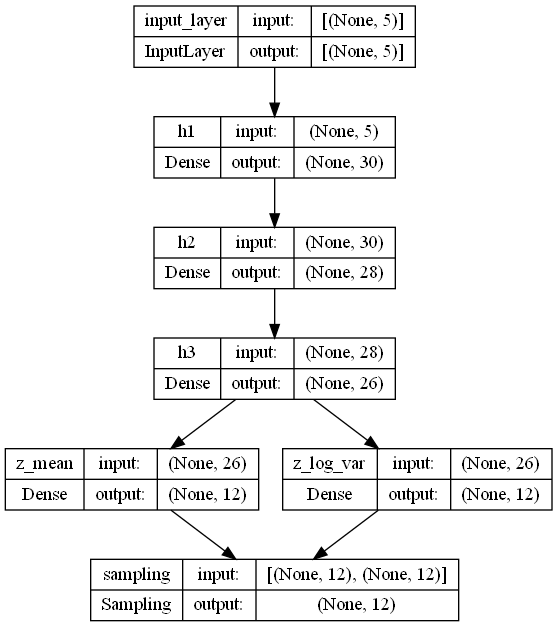

In [251]:
keras.utils.plot_model(encoder, show_shapes=True)

In [285]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x4 = Dense(26, activation="relu", name="h4")(latent_inputs)
x5 = Dense(28, activation="relu", name="h5")(x4)
x6 = Dense(30, activation="relu", name="h6")(x5)
cont_decoder_outputs = Dense(4)(
    x6
)  # Output shape modified to match input
class_decoder_output = Dense(1, activation="softmax", name="classification_output")(
    x6
)

decoder = keras.Model(latent_inputs, [cont_decoder_outputs, class_decoder_output], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 h4 (Dense)                     (None, 26)           338         ['input_20[0][0]']               
                                                                                                  
 h5 (Dense)                     (None, 28)           756         ['h4[0][0]']                     
                                                                                                  
 h6 (Dense)                     (None, 30)           870         ['h5[0][0]']                     
                                                                                            

In [286]:
# VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = (
                keras.losses.mean_squared_error(data, reconstruction)
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [287]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [244]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Generate 1000 lines, each with 6 elements drawn from a normal distribution
data = np.random.normal(loc=0, scale=1, size=(10000, 2))


In [245]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your input data
# Specify the test_size and validation_size according to your needs
test_size = 0.2  # 80% training, 20% test
validation_size = 0.1  # 80% training, 10% validation

# Split into training and temporary data
train_data, temp_data = train_test_split(
    data, test_size=test_size + validation_size, random_state=42
)

# Split the temporary data into test and validation
test_data, validation_data = train_test_split(
    temp_data,
    test_size=validation_size / (test_size + validation_size),
    random_state=42,
)


# Convert NumPy arrays to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation_data, validation_data)
)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data))

In [288]:
vae.fit(synthetic_array, epochs=30, batch_size=128)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Max_G\AppData\Local\Temp\ipykernel_1148\3642612222.py", line 26, in train_step
        keras.losses.mean_squared_error(data, reconstruction)
    File "c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\keras\losses.py", line 1484, in mean_squared_error
        y_pred = tf.convert_to_tensor(y_pred)

    ValueError: Dimension 1 in both shapes must be equal, but are 4 and 1. Shapes are [?,4] and [?,1].
    	From merging shape 0 with other shapes. for '{{node packed}} = Pack[N=2, T=DT_FLOAT, axis=0](decoder/dense_18/BiasAdd, decoder/classification_output/Softmax)' with input shapes: [?,4], [?,1].


In [ ]:
latent_vectors = np.random.normal(size=(10000, latent_dim))

# Use the decoder to generate data
generated_data = vae.decoder.predict(latent_vectors)

313/313 [==============================] - 0s 895us/step


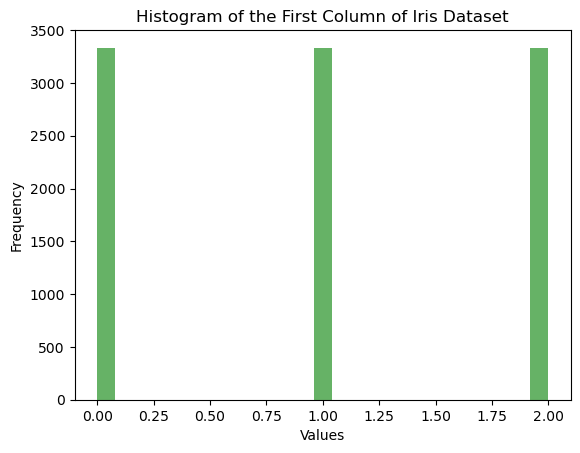

In [ ]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
first_column = synthetic_array[:, 4]

# Plot histogram
plt.hist(first_column, bins=25, color="g", alpha=0.6)
plt.title("Histogram of the First Column of Iris Dataset")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

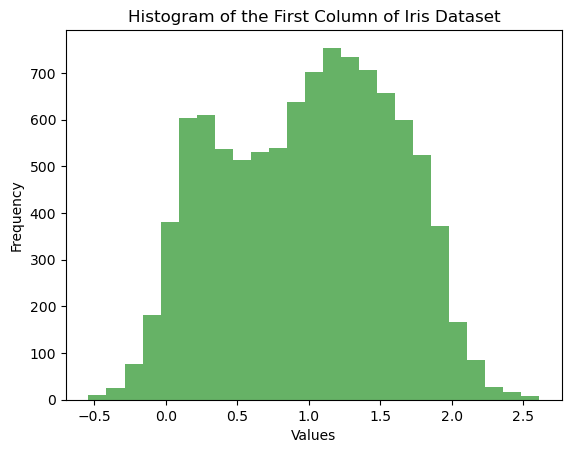

In [ ]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
first_column = generated_data[:, 4]

# Plot histogram
plt.hist(first_column, bins=25, color="g", alpha=0.6)
plt.title("Histogram of the First Column of Iris Dataset")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

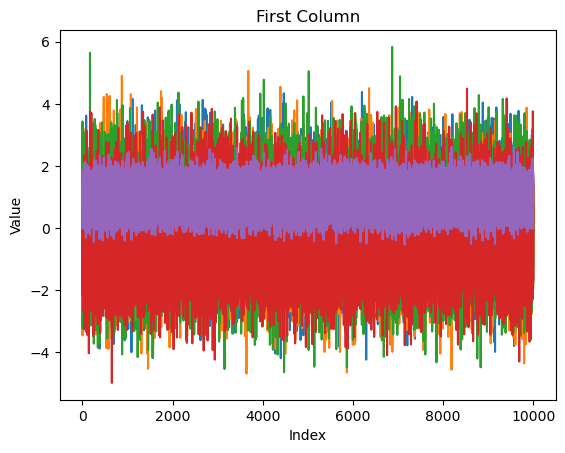

In [ ]:
first_column = generated_data[:, ]

# Plot the first column
plt.plot(first_column)
plt.title("First Column")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [ ]:
from scipy.stats import norm, shapiro

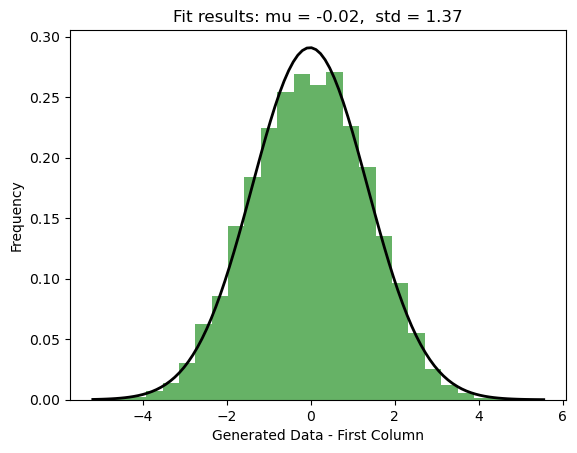

Shapiro-Wilk test p-value: 1.119886405831494e-06


c:\Users\Max_G\anaconda3\envs\var_auto\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
from scipy.stats import norm, shapiro
import matplotlib.pyplot as plt

# Assuming 'generated_data' is a 1D array or list
first_column = generated_data[:, 1]

# Fit a normal distribution to the data
mu, std = norm.fit(first_column)

# Create a histogram of the data
plt.hist(first_column, bins=25, density=True, alpha=0.6, color="g")

# Plot the PDF of the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)

# Title and labels
plt.title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.xlabel("Generated Data - First Column")
plt.ylabel("Frequency")

# Display the plot
plt.show()

# Shapiro-Wilk test for normality
stat, p_value = shapiro(first_column)
print("Shapiro-Wilk test p-value:", p_value)

# You can also use other normality tests like Anderson-Darling
# from scipy.stats import anderson
# result = anderson(first_column)
# print("Anderson-D